# Notebook 05: Regression - Predicting Sales for New Models

This notebook develops a regression model and evaluates predictions for new model sales using attributes for watches in datasets cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer

# custom function imports
from custom_functions import *
from regression_custom_functions import *

In [2]:
# Import data
df_all_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

# Create a new dataframe with only models where there is historical sales data
time_now = datetime.datetime.now()
df_models = df_all_models.dropna(subset=time_now.strftime(f"%Y-%m"))

# Create new data frame with attributes from model to make predictions for new models in proposal
df_new_models = df_all_models[df_all_models[time_now.strftime(f"%Y-%m")].isna()]

### Train-test split

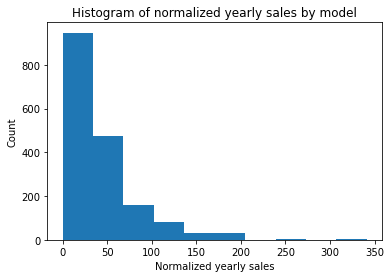

In [3]:
# Calculate a target value - Normalized Sales, which is the model yearly sales divided by the average yearly sales and by the number of years that the model was sold
# Note, you can only run this cell once
df_models = calc_norm_yearly_sales(df_models,4,2019)

In [4]:
# Create X & y for model creation using attributes
attributes = ['country_of_origin','warranty', 'band_color', 'band_material',
       'case_material', 'dial_color', 'case_size', 'color',
       'retail_price', 'collection', 'clasp_type', 'water_resistance',
       'movement_type']

X = df_models[attributes]
y = df_models['norm_yearly_sales']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Check no null values in X
X.isna().sum().sum() #Should return 0

0

In [5]:
# Create test set for later model testing
test = df_new_models[attributes]

# Impute missing retail prices
knn_imp = KNNImputer()
test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])

# Check no null values in test
test.isna().sum().sum() #Should return 0

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_21311/1977101099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])


0

## Baseline Model

In [6]:
baseline = np.full_like(y_test, y_train.mean())

In [7]:
rmse_baseline = mean_squared_error(y_test,baseline,squared=False)
rmse_baseline

34.324684839077996

In [8]:
residuals_baseline = y_test - baseline

In [9]:
r2_baseline = r2_score(y_test,baseline)
r2_baseline

-0.01253073615121747

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


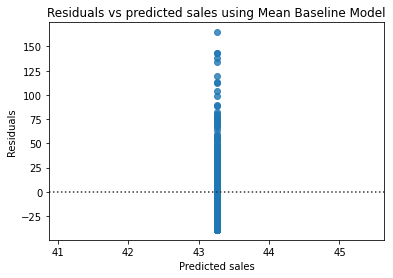

In [10]:
sns.residplot(x = baseline,
              y = residuals_baseline,
              lowess = True,
              line_kws = {'color':'red'})
plt.title('Residuals vs predicted sales using Mean Baseline Model')
plt.xlabel('Predicted sales')
plt.ylabel('Residuals');

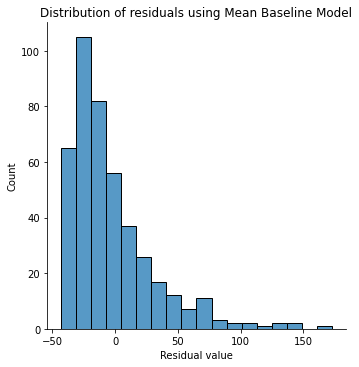

In [11]:
# Create residuals histogram to check for normal distribution of errors
sns.displot(residuals_baseline, binwidth =12)
plt.title('Distribution of residuals using Mean Baseline Model')
plt.xlabel('Residual value');

Definitely not normally distributed. There is a tail for the higher sales models.

## Exploring different models for initial model identification

LinearRegression()
Train score: 0.6200021980995354
Test raw score: -3.8496677467797846e+24
Test cleaned score: 0.21875625678354382
Test cleaned RMSE: 30.150583870273
Baseline RMSE: 34.324684839077996

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train score: 0.5825705459978874
Test raw score: 0.30010868729541595
Test cleaned score: 0.3024554731750345
Test cleaned RMSE: 28.48973557194334
Baseline RMSE: 34.324684839077996

LassoCV(alphas=array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00]))


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193436.98802330717, tolerance: 200.27904278108096
  model = cd_fast.enet_coordinate_descent_gram(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

Train score: 0.4952412320225842
Test raw score: 0.27637498949029915
Test cleaned score: 0.27637980155646347
Test cleaned RMSE: 29.017352868596458
Baseline RMSE: 34.324684839077996

KNeighborsRegressor(n_neighbors=3)
Train score: 0.6252245822251314
Test raw score: 0.008563181998774483
Test cleaned score: 0.008563181998774483
Test cleaned RMSE: 33.96526223897897
Baseline RMSE: 34.324684839077996

RandomForestRegressor(n_estimators=500)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train score: 0.884124431826987
Test raw score: 0.36234747864037975


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test cleaned score: 0.36234747864037975
Test cleaned RMSE: 27.239208957956382
Baseline RMSE: 34.324684839077996

AdaBoostRegressor(base_estimator=RandomForestRegressor())
Train score: 0.7581203813664721


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test raw score: 0.17033300483770242


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test cleaned score: 0.17033300483770242
Test cleaned RMSE: 31.070937512430014
Baseline RMSE: 34.324684839077996

ExtraTreesRegressor(n_estimators=200)
Train score: 0.9513769624050542
Test raw score: 0.11809392601101842
Test cleaned score: 0.11809392601101842
Test cleaned RMSE: 32.03418043895491
Baseline RMSE: 34.324684839077996


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Best RMSE: 27.239208957956382
Best model: rf


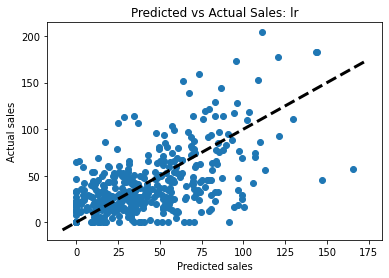

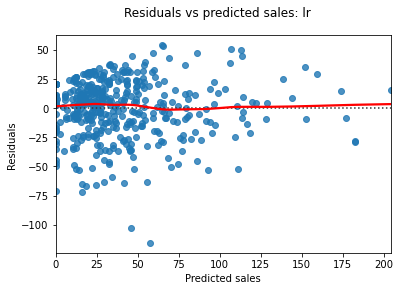

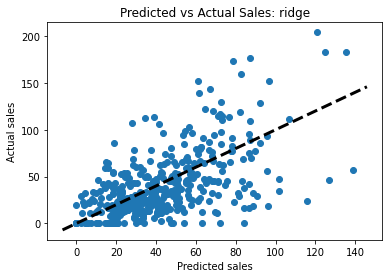

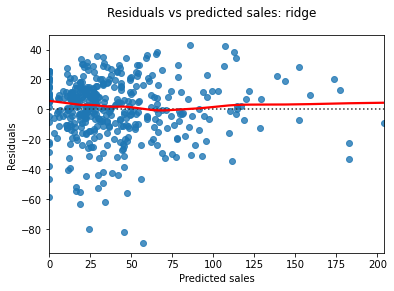

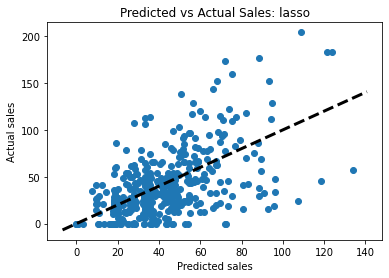

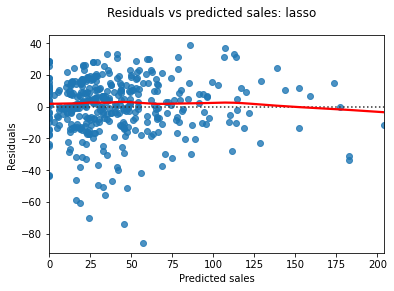

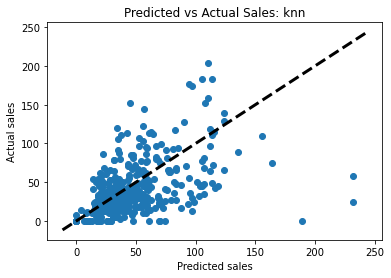

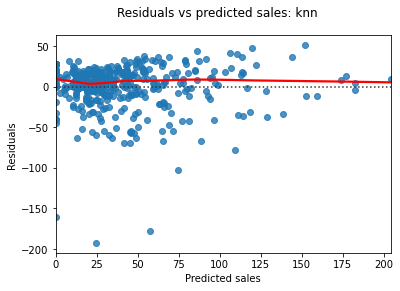

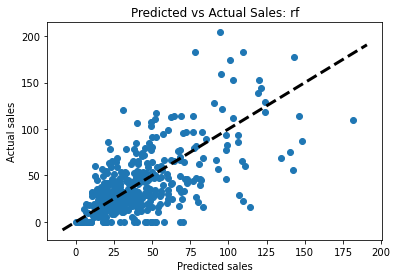

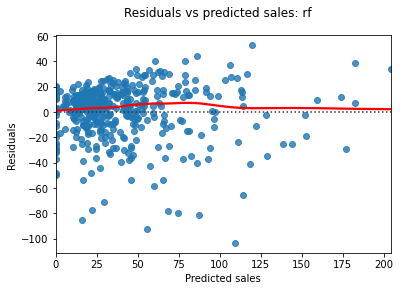

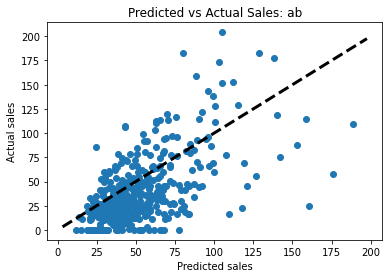

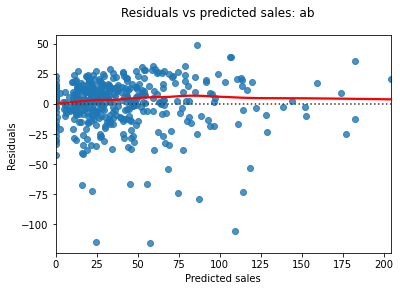

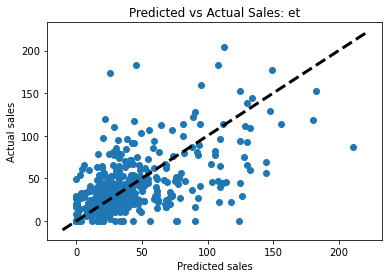

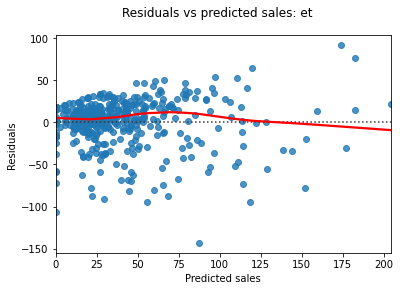

In [12]:
# Instantiate various model types to feed into a function that creates and evaluates various the models
# This will be used to quickly narrow down models that will be further tuned for a final production model
models = [('lr',LinearRegression()), ('ridge',RidgeCV(alphas=np.logspace(0,5,100))),
          ('lasso',LassoCV(alphas=np.arange(0.001,10,1))),('knn',KNeighborsRegressor(n_neighbors=3)),
          ('rf', RandomForestRegressor(n_estimators=500)), ('ab', AdaBoostRegressor(base_estimator=RandomForestRegressor())),
          ('et', ExtraTreesRegressor(n_estimators=200))]

best_rmse = 1000000
df_preds = pd.DataFrame(y_test.values, columns=['y_test'])

for model in models:
    preds, rmse = create_evaluate_model(model, X_train, X_test, y_train, y_test)
    df_preds[f'preds_{model[0]}'] = preds
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model[0]
        
print('Best RMSE:', best_rmse)
print('Best model:', best_model)

In [13]:
df_preds_avg = df_preds[['preds_ridge','preds_rf']]
df_preds['avg'] = 0
for pred in df_preds_avg:
    df_preds['avg'] = df_preds['avg'] + df_preds_avg[pred]
df_preds['avg'] = df_preds['avg']/len(df_preds_avg.columns)

In [14]:
df_preds

,y_test,preds_lr,preds_ridge,preds_lasso,preds_knn,preds_rf,preds_ab,preds_et,avg
0,28.267594,25.906596,33.476491,35.500204,29.812890,32.741373,38.299807,32.759392,33.108932
1,41.505741,69.465190,57.285838,47.727411,73.858801,72.510434,81.281768,94.012254,64.898136
2,53.805277,46.969096,49.743166,48.740770,32.538933,44.163976,50.541877,43.281797,46.953571
3,0.000000,14.070659,18.527752,21.026582,9.495222,9.828963,25.579884,15.862088,14.178358
4,52.066305,62.344096,59.423048,49.870564,60.963625,60.018296,60.790604,60.931393,59.720672
...,...,...,...,...,...,...,...,...,...
426,21.522790,1.969096,20.960465,9.903099,42.298349,15.248069,27.020325,8.504180,18.104267
427,65.868841,42.812846,45.593264,57.506065,83.160785,23.939858,36.768889,5.733236,34.766561
428,0.000000,0.000000,16.341714,35.630890,25.483706,20.667852,37.080208,29.500700,18.504783
429,0.000000,0.000000,6.054121,21.658113,28.148773,29.009483,31.807885,35.483249,17.531802


In [15]:
mean_squared_error(y_test,df_preds['avg'],squared=False)

26.064304235910154

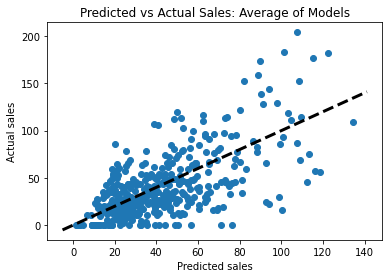

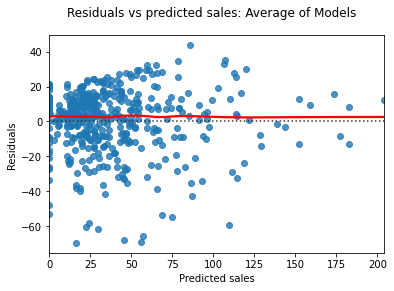

In [16]:
plot_preds(df_preds['y_test'],df_preds['avg'],'Average of Models')

## Example model

In [17]:
# We will use one of the best models evaluated in the exploration to compare against planned orders for new models
# Create a column transformer to one hot encode categorical variables
categorical_attributes = []
for attribute in X_train.columns:
    try:
        int(attribute)
    except:
        categorical_attributes.append(attribute)

# Setup pipeline for preprocessing and modeling
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
                         categorical_attributes)],
                      remainder='passthrough',
                      verbose_feature_names_out=False)
pipe = Pipeline([
    ('ct',ct),
    ('ss',StandardScaler()),
    ('rf',RandomForestRegressor())
])

# Fit model with train set
pipe.fit(X_train,y_train)

# Generate predictions for new models
preds = pipe.predict(test)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### Compare the distributions of planned order and predicted order

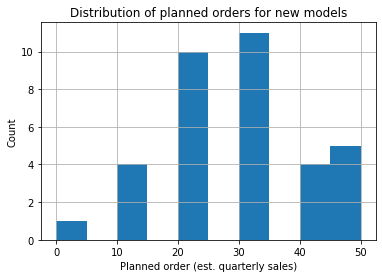

In [18]:
df_new_models.planned_order.hist()
plt.title('Distribution of planned orders for new models')
plt.xlabel('Planned order (est. quarterly sales)')
plt.ylabel('Count');

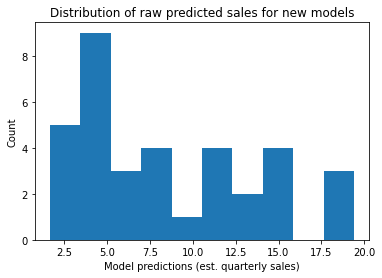

In [23]:
plt.hist(preds/4)
plt.title('Distribution of raw predicted sales for new models')
plt.xlabel('Model predictions (est. quarterly sales)')
plt.ylabel('Count');

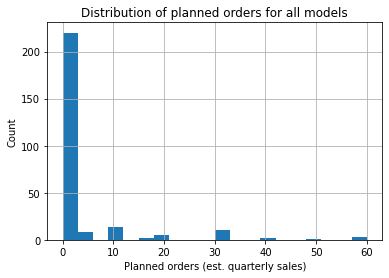

In [22]:
df_models.planned_order.hist(bins = 20)
plt.title('Distribution of planned orders for all models')
plt.xlabel('Planned orders (est. quarterly sales)')
plt.ylabel('Count');

In [21]:
# Save new model predictions (monthly order) to csv
new_model_predictions = df_new_models[['style_id']]
new_model_predictions[f'monthly_predictions_Q{(time_now.month - 1 ) // 3 + 1 + 1}'] = preds/12
new_model_predictions.to_csv('../data/predictions/new_models_regression.csv',index=False)

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_21311/191797093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_predictions[f'monthly_predictions_Q{(time_now.month - 1 ) // 3 + 1 + 1}'] = preds/12


## Discussion

The best performing model (without tuning) generates predictions that tend to underpredict the planned orders, and are not easily adjustable for changes in overall sales. Instead of further tuning a regression model, I instead turn to a classification model to categorize watch sales and generate orders based on classification. I believe this may be more effective and more nimble to adjust for future changes in sales.